# Assignment 2

__41934 - Advanced BIM, E23__


Kaare G. S. Hansen, s214282 - DTU




BIM ideer:
- Byg etager oven på hindanden, forstør søjler etc...
- Ændre nyttelast i spaces, lav ny geometri, lav FEM-model
- Opennest, produktionstegninger

## Todo

- [ ] Bounding box to plane
- [ ] Project wall and slab to plane, generate mesh
- [ ] Beam/Column, lines, find common FEM-knots
- [ ] Connect wall/slab mesh to beam/columns
- [ ] Apply self-weight load
- [ ] Apply load from IfcSpaces/zones
- [ ] Create IfcStructuralAnalysisModel
- [ ] Analyse IfcStructuralAnalysisModel with PyNiteFEA
- [ ] Brug IFC-load method fra kursus

**Todo nu**:
- ~~[ ] Plotly af guids~~
- [ ] Find samling af bjælker, søjler til udviklingseksempel
- [ ] Abstract base class til analyticalModel


**First step!** Just make MVP that barely works... Accuracy doesn't matter...

## Ideas
- Detect knots by end of beam/column lines
- Detect knots by enlarging obb slightly and doing checks..

## Limitations
- All analytical connections have zero DOF
- 

## Imports

In [1]:
import os
import sys
import multiprocessing
from collections import namedtuple
import numpy as np
import pandas as pd
import ifcopenshell
import ifcopenshell.util.placement
import ifcopenshell.geom
import ifcopenshell.util.shape
import ifcopenshell.util.selector

print(f"ifcopenshell version: {ifcopenshell.version}")
print(f"Python-version {sys.version}")

ifcopenshell version: 0.7.0
Python-version 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
from geomUtils import *
from ifcUtils import *
from rendering import *
import utils

In [3]:
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.gp import gp_Pnt, gp_Ax2, gp_Dir, gp_XYZ
from OCC.Core.BRepBndLib import brepbndlib
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.Bnd import Bnd_OBB
from OCC.Core.BRepTools import breptools_Read
from OCC.Core.TopoDS import TopoDS_Shape
from OCC.Core.BRep import BRep_Builder
from OCC.Core.GC import GC_MakeArcOfCircle, GC_MakeSegment

from OCC.Display.SimpleGui import init_display
from OCC.Display.OCCViewer import rgb_color

from OCC.Core.gp import gp_Pnt, gp_Dir, gp_Lin
from OCC.Core.Geom import Geom_Line, Geom_Point, Geom_CartesianPoint
from OCC.Core.AIS import AIS_Line, AIS_Point
from OCC.Core.Prs3d import Prs3d_LineAspect, Prs3d_Drawer
from OCC.Core.Quantity import Quantity_Color, Quantity_TOC_RGB
from OCC.Core.Graphic3d import Graphic3d_ZLayerSettings
from OCC.Core.TColStd import TColStd_SequenceOfInteger


In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "png"
pio.renderers.default = "plotly_mimetype+png"

## Load models

In [5]:
models = load_models()

File path, ark: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab/LLYN - ARK.ifc
Model schema: IFC4

File path, stru: /Users/Kaare/My Drive/DTU/Kurser/Videregaaende BIM - 41934/IFC-models\SkyLab/LLYN - STRU.ifc
Model schema: IFC4



In [6]:
model = models['stru']
# model = models['ark']

In [7]:
shapeData, tree, unit_magnitude, unit_name = processGeometry(model)

Beginning processing with 12 threads...
Progress: 0 0%
Progress: 0 16%
Progress: 0 28%
Progress: 0 44%
Progress: 0 70%
Progress: 0 100%
Progress: 0 100%
Progress: 0 100%
Processed 3601 items
Contexts: {'FootPrint', 'Axis', 'Body'}


## Tests

In [8]:
wall = model.by_type('IfcWall')[200]
wall

#32341=IfcWall('1s4iAtHXv8f89265OVfcKx',#18,'Basic Wall:VE20-0:2203117',$,'Basic Wall:VE20-0',#32308,#32340,'2203117',.NOTDEFINED.)

In [9]:
# data = shapeData['1s4iAtHXv8f89265OVfcKx']['Body']
# data

In [10]:
settings = ifcopenshell.geom.settings()
shape = ifcopenshell.geom.create_shape(settings, wall)

In [11]:
materials = shape.geometry.materials
material_ids = shape.geometry.material_ids
for mat in materials:
    print(mat.name)
    print(mat.original_name())

print(material_ids)

surface-style-325-4.-(ve)-v--gelement
4. (VE) Vægelement
(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


In [12]:
model.by_type('IfcMaterial')

[#182=IfcMaterial('5. (DE) Dækelement',$,'Materials'),
 #286=IfcMaterial('3. (DK) Terrændæk',$,'Materials'),
 #330=IfcMaterial('4. (VE) Vægelement',$,'Materials'),
 #702=IfcMaterial('4. (SE) Elementsøjle',$,'Materials'),
 #706=IfcMaterial('@_DE_Beton Element',$,'Materials'),
 #3376=IfcMaterial('4. (SB) Stålbjælke',$,'Materials'),
 #5369=IfcMaterial('2. (FS) Liniefundament',$,'Materials'),
 #5941=IfcMaterial('2. (FPB) Brøndfundament',$,'Materials'),
 #6528=IfcMaterial('2. (FSS) Fundamentssokkel, stribe',$,'Materials'),
 #6619=IfcMaterial('4. (VG) Vægge, pladsstøbt',$,'Materials'),
 #7923=IfcMaterial('2. (FP) Punktfundament',$,'Materials'),
 #8008=IfcMaterial('2. (FSP) Fundamentssokkel, punkt',$,'Materials'),
 #8357=IfcMaterial('@_IH_Isolering Hård',$,'Materials'),
 #8583=IfcMaterial('2. (FSG) Liniefundament, grovbeton',$,'Materials'),
 #10125=IfcMaterial('5. (DK) Pladsstøbte dæk',$,'Materials'),
 #11719=IfcMaterial('2.(FLP) Pladefundament',$,'Materials'),
 #26593=IfcMaterial('4. (SB) St

In [13]:
def displayAllFunc(renderer, **args):
    data = args['data']

    # global viewer
    viewer = renderer.Viewer
    viewer.Erase()

    layerIndices = TColStd_SequenceOfInteger()
    viewer.GetAllZLayers(layerIndices)
    for i in range(1, layerIndices.Size() + 1):
        didDelete = viewer.RemoveZLayer(layerIndices.Value(i))
        if didDelete: print("Deleted one!")

    # #create 2 layers with different settings
    # settings_1 = Graphic3d_ZLayerSettings()
    # layer_created_1, layer_id_1 = viewer.AddZLayer(settings_1)
    # if layer_created_1:
    #     print("Layer 1 successfully created")
    #     print("Layer 1 id:", layer_id_1)

    # settings_2 = Graphic3d_ZLayerSettings()
    # layer_created_2, layer_id_2 = viewer.AddZLayer(settings_2)
    # if layer_created_1:
    #     print("Layer 2 successfully created")
    #     print("Layer 2 id:", layer_id_2)

    for i, (GUID, shape) in enumerate(data.items()):
        to_update = i % 50 == 0
        if shape.get('Body') and True:
            pdct_shape = shape['Body']

            if pdct_shape.data.type in ['IfcBeam']:
                transparency = 0.1
            else:
                transparency = 0.9

            r,g,b,alpha = pdct_shape.styles[0] # the shape color
            color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

            renderer.DisplayShape(
                pdct_shape.geometry,
                color = color,
                # transparency=abs(1 - alpha),
                transparency=transparency,
                update=to_update,
            )
        
        if shape.get('Axis') and True:
            pdct_shape = shape['Axis']

            [ais] = renderer.DisplayShape(pdct_shape.geometry)
            width = float(15.0)
            ais.SetWidth(width)
            # ais.SetZLayer(layer_id_1)

        if shape.get('FootPrint') and True:
            pdct_shape = shape['FootPrint']

            color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)

            renderer.DisplayShape(
                pdct_shape.geometry,
                color=color,
            )

    renderer.Viewer.DisplayPrivilegedPlane(True, 100.0)
    renderer.FitAll()
    print("Done...")

Done...


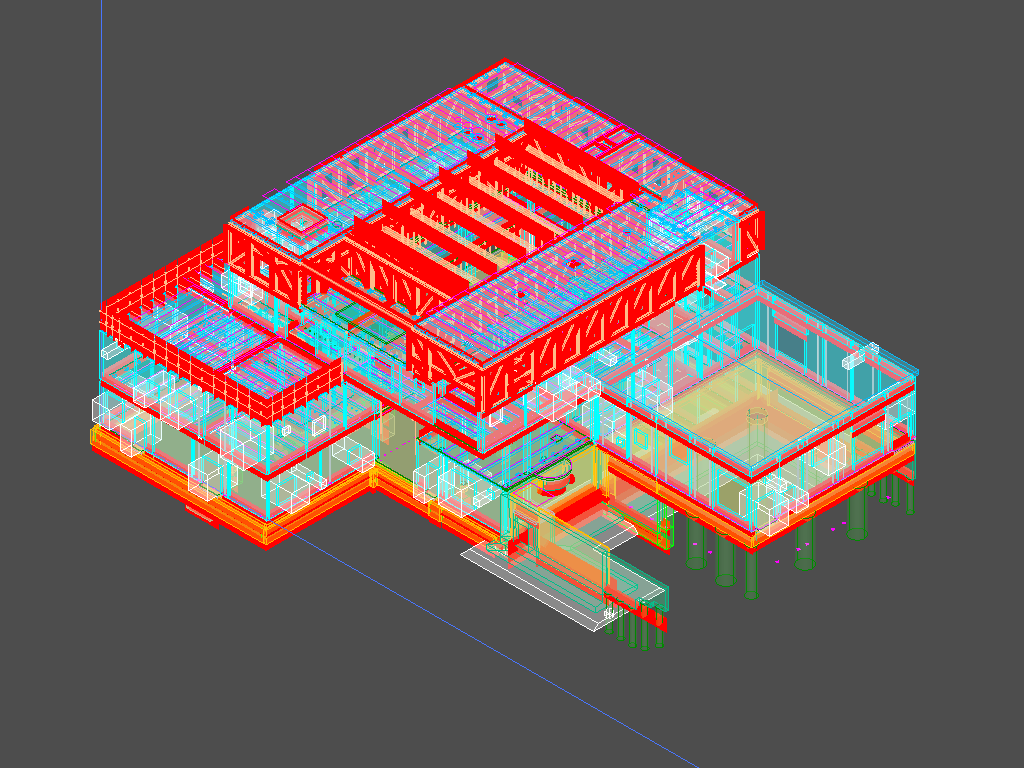

In [14]:
# RenderInWindow(displayAllFunc, data=shapeData)
RenderImage(displayAllFunc, data=shapeData)

### Load bearing elements

In [15]:
load_bearing = getLoadBearing(model)
load_bearing = {elm.GlobalId: elm for elm in load_bearing}
len(load_bearing)

Number of load-bearing elements: 1750
Unique types of loadbearing elements:
 {'IfcSlab', 'IfcBeam', 'IfcColumn', 'IfcWall'}


1750

In [16]:
loadBearing_shapeData = {GUID: shapeData[GUID] for GUID in load_bearing.keys()}
len(loadBearing_shapeData)

1750

In [18]:
import OCC.Core
import OCC.Core.BRep
import OCC.Core.BRepPrimAPI
import OCC.Core.BRepTools

## Get IfcBeams as lines

In [19]:
bearingElements = dict()
for GUID, elm in load_bearing.items():
    key = elm.is_a()
    if not key in bearingElements:
        bearingElements[key] = list()
    
    bearingElements[key].append(elm)

[f"{key}: {len(val)}" for key, val in bearingElements.items()]

['IfcWall: 368', 'IfcColumn: 452', 'IfcSlab: 365', 'IfcBeam: 565']

In [20]:
beams = bearingElements['IfcBeam']
columns = bearingElements['IfcColumn']
slabs = bearingElements['IfcSlab']
walls = bearingElements['IfcWall']
elements = [*beams, *columns, *slabs, *walls]
elementsColWalls = [*beams, *columns]

### Display single beam

In [21]:
beam = beams[99]
beam

#48618=IfcBeam('3cnJuO8zzBPenu_2r6jqB3',#18,'Rectangular and Square Hollow Sections:SB10:2520488',$,'Rectangular and Square Hollow Sections:SB10',#48617,#48614,'2520488',.BEAM.)

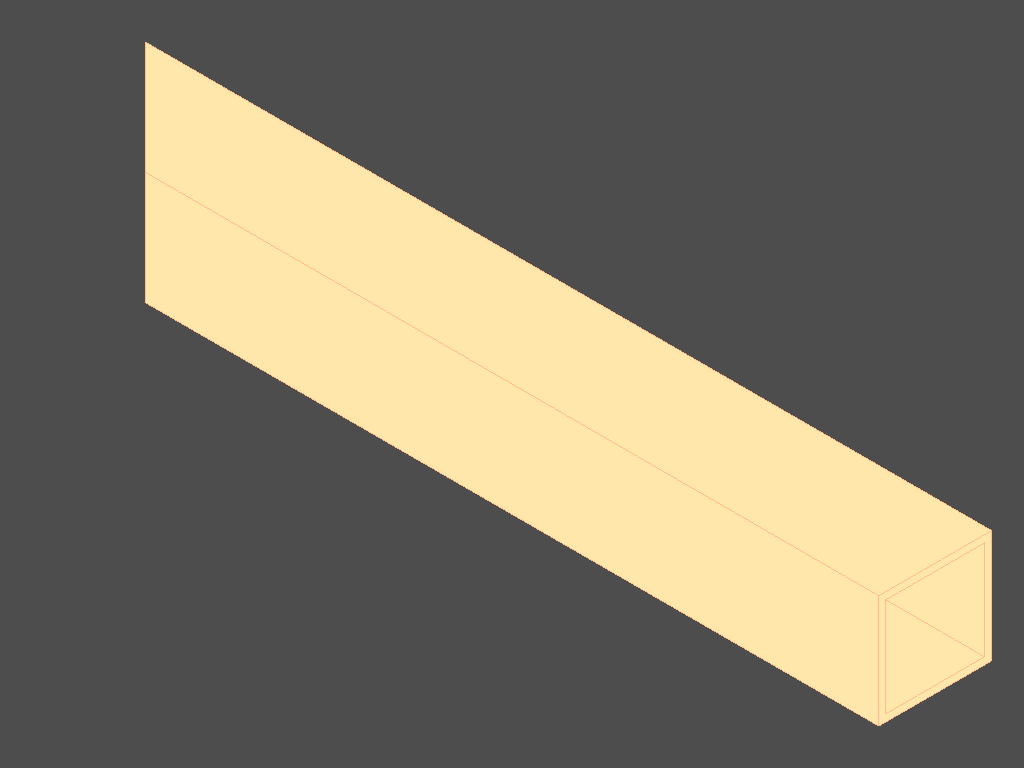

In [22]:
RenderImage(ElementsRenderFunc, elements={beam.GlobalId: beam})

### Display lines

In [23]:
beamCurves = getCurveShapes(beams)
print(len(beamCurves))
# columnCurves = getCurveShapes(columns)
curveShapes = [*beamCurves]

565


C:\Users\Kaare\AppData\Local\Temp\ipykernel_22176\3712244744.py:1: DeprecationWarning:

Call to deprecated function (or staticmethod) getCurveShapes. (Use processGeometry instead)



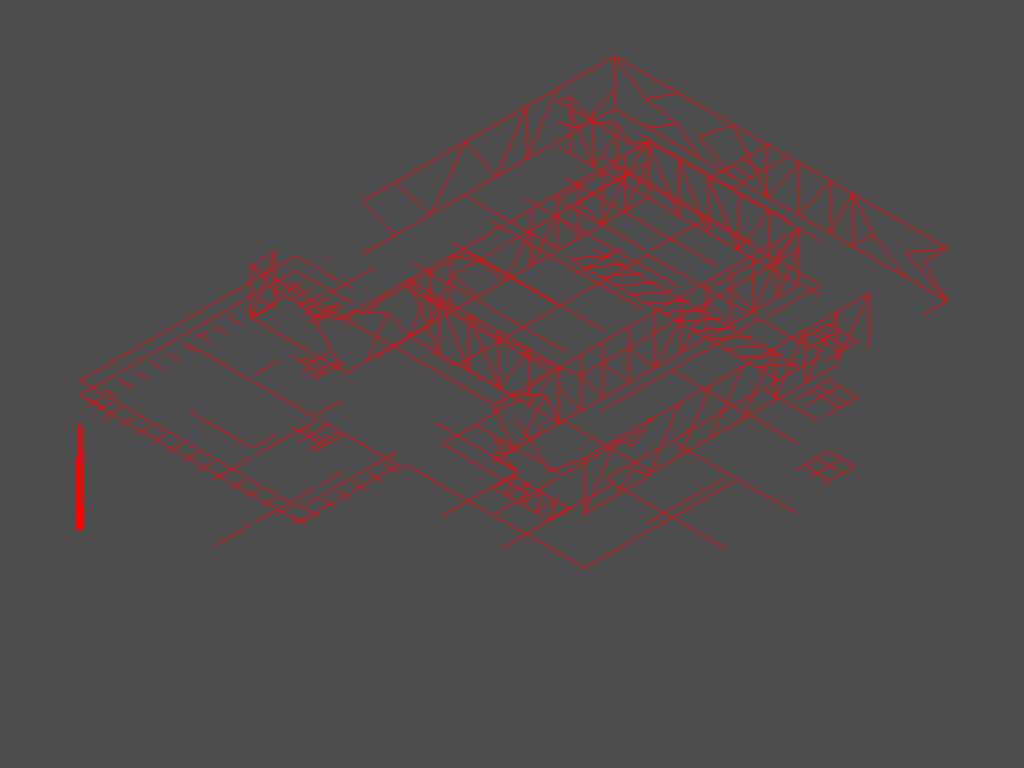

In [24]:
# RenderInWindow(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])
RenderImage(SimpleRenderFunc, shapes=[curve.geometry for curve in curveShapes])

### Display everything...

In [25]:
# elements = models['ark'].by_type('IfcBuildingElement')
elements = models['stru'].by_type('IfcBuildingElement')

In [26]:
def customRenderFunc(renderer, **args):
    elements = args['elements']
    elements_render = [elements[i] for i in range(1000)]
    
    for i, element in enumerate(elements_render):
        try:
            if (
                element.Representation is not None
            ):

                # body = ifcopenshell.util.representation.get_representation(element, "Model", "Body")
                # body_repr = ifcopenshell.util.representation.resolve_representation(body)
                # pdct_shape = ifcopenshell.geom.create_shape(settings, inst=element, repr=body_repr)

                pdct_shape = ifcopenshell.geom.create_shape(settings, inst=element)

                r, g, b, alpha = pdct_shape.styles[0]  # the shape color
                color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

                # print(f"pdct styles {len(pdct_shape.styles)}")

                # below, the pdct_shape.geometry is a TopoDS_Shape, i.e. can be rendered using
                # any renderer (threejs, x3dom, jupyter, qt5 based etc.)
                to_update = i % 50 == 0
                if True:
                    renderer.DisplayShape(
                        # pdct_shape.geometry, shape_color=color, transparency=True, opacity=alpha
                        pdct_shape.geometry,
                        # pdct_shape[1],
                        color=color,
                        transparency=abs(1 - alpha),
                        # transparency=alpha,
                        # transparency=0.7,
                        update=to_update,
                    )

                # Oriented bounding box
                if False:
                    elmShape = pdct_shape.geometry
                    obb = Bnd_OBB()
                    brepbndlib.AddOBB(elmShape, obb, True, True, True)
                    obb_shape = convert_bnd_to_shape(obb)
                    renderer.DisplayShape(obb_shape, color=rgb_color(1.0, 0.0, 1.0), transparency=0.8)

                    ais_line = convert_bnd_to_line(obb)


                    # lineSeg = GC_MakeSegment(pnt, pnt2).Value()
                    # ais_line = AIS_Line(lineSeg)


                    # pt1 = Geom_CartesianPoint(pnt)
                    # pt2 = Geom_CartesianPoint(pnt2)
                    # ais_line = AIS_Line(pt1, pt2)
                    # print(type(ais_line))
                    # print(type(z_dir))
                    # line = gp_Lin(pnt, z_dir)

                    # ais_pnt = AIS_Point(pnt)
                    # ais_line = ais_pnt
                    width = float(3.0)
                    drawer = ais_line.Attributes()
                    ais_line.SetWidth(width)

                    # asp : first parameter color, second type, last width
                    i = 1
                    asp = Prs3d_LineAspect(Quantity_Color(9 * i), i, width*5.0)
                    # drawer.SetLineAspect(asp)
                    # drawer.SetLineArrowDraw(True)
                    ais_line.SetAttributes(drawer)
                    # renderer.DisplayShape(ais_line)
                    renderer.Context.Display(ais_line, False)
                    # renderer.DisplayShape(pnt, color=rgb_color(0.0, 1.0, 0.0))
                    # renderer.DisplayShape(lineSeg, color=rgb_color(1.0, 1.0, 0.0))
                    # renderer.DisplayShape(pnt2, color=rgb_color(1.0, 1.0, 0.0))

            else:
                print(f"Product has no representation!, {element.get_info()}")

        except Exception as e:
            print(f"Error! {e}")
            print(f"Regarding element {element.get_info()}")


    # renderer.SetRaytracingMode(depth=4)
    renderer.FitAll()

Error! 'TriangulationElement' object has no attribute 'styles'
Regarding element {'id': 180, 'type': 'IfcSlab', 'GlobalId': '02OD1_RP5Akg$FG0k2tjDn', 'OwnerHistory': #18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1662038022), 'Name': 'Floor:DS01:571984', 'Description': None, 'ObjectType': 'Floor:DS01', 'ObjectPlacement': #131=IfcLocalPlacement(#112,#130), 'Representation': #179=IfcProductDefinitionShape($,$,(#178)), 'Tag': '571984', 'PredefinedType': 'FLOOR'}
Error! 'TriangulationElement' object has no attribute 'styles'
Regarding element {'id': 252, 'type': 'IfcSlab', 'GlobalId': '2lzvWnk9X869vk5tLbtMms', 'OwnerHistory': #18=IfcOwnerHistory(#17,#2,$,.NOCHANGE.,$,$,$,1662038022), 'Name': 'Floor:DE22:579393', 'Description': None, 'ObjectType': 'Floor:DE22', 'ObjectPlacement': #200=IfcLocalPlacement(#112,#199), 'Representation': #251=IfcProductDefinitionShape($,$,(#250)), 'Tag': '579393', 'PredefinedType': 'FLOOR'}
Error! 'TriangulationElement' object has no attribute 'styles'
Regarding e

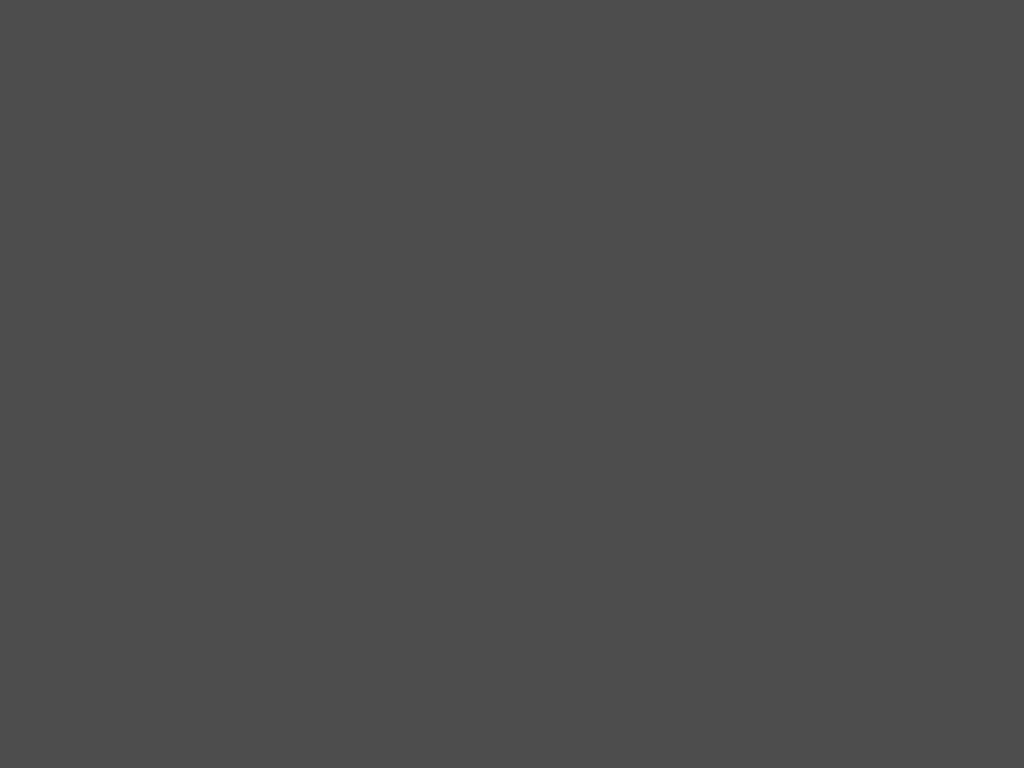

In [27]:
# RenderInWindow(customRenderFunc, elements=elements)
RenderImage(customRenderFunc, elements=elements)

## Example connections

### 3 steel beams, 1 steel column, corner

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-28-53.png)

In [28]:
guids = [
    "1gWnGCa$TAouEuWitQnG6O",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnG5y",
    "1gWnGCa$TAouEuWitQnG6A",
    # "2RiPt4b_L7lu6usHtxHmZS", # IfcSlab above
    "1gWnGCa$TAouEuWitQnG5o", # Extras
    "1gWnGCa$TAouEuWitQnGB2",
]

In [29]:
elements = [model.by_guid(guid) for guid in guids]
elements

[#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangular and Square Hollow Sections:SB40',#20667,#20664,'1803904',.BEAM.),
 #17051=IfcBeam('1gWnGCa$TAouEuWitQnG5y',#18,'H-Wide Flange Beams:SB30:1803712',$,'H-Wide Flange Beams:SB30',#17050,#17047,'1803712',.BEAM.),
 #14440=IfcBeam('1gWnGCa$TAouEuWitQnG6A',#18,'H-Wide Flange Beams:SB30:1803574',$,'H-Wide Flange Beams:SB30',#14439,#14436,'1803574',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #20577=IfcBeam('1gWnGCa$TAouEuWitQnGB2',#18,'Rectangular and Square Hollow Sections:SB40:1803902',$,'Rectangular and Square Hollow Sections:SB40',#20576,#20573,'1803902',.BEAM.)]

In [30]:
from OCC.Core.Prs3d import Prs3d_Text
from OCC.Core.Graphic3d import Graphic3d_Group, Graphic3d_Text
from OCC.Core.TCollection import TCollection_AsciiString, TCollection_ExtendedString
from OCC.Core.Quantity import Quantity_Color
from OCC.Core.gp import gp_Pnt
from OCC.Core.Aspect import Aspect_TOL_SOLID
from OCC.Core.AIS import AIS_TextLabel

In [31]:
def renderElementsOBB(renderer, **args):
    elements_shape = args['elements_shape']
    elements_obb = args['elements_obb']

    for GUID, pdct_shape in elements_shape.items():
        try:

            r, g, b, alpha = pdct_shape.styles[0]  # the shape color
            color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

            renderer.DisplayShape(
                # pdct_shape.geometry, shape_color=color, transparency=True, opacity=alpha
                pdct_shape.geometry,
                # pdct_shape[1],
                color=color,
                transparency=abs(1 - alpha),
                # transparency=alpha,
                # transparency=0.7,
            )

        except Exception as e:
                print(f"Error! {e}")


    for GUID, obb in elements_obb.items():
        try:
            obb_shape = convert_bnd_to_shape(obb)
            renderer.DisplayShape(obb_shape, color=rgb_color(1.0, 0.0, 1.0), transparency=0.8)

            ais_line = convert_bnd_to_line(obb)

            width = float(3.0)
            drawer = ais_line.Attributes()
            ais_line.SetWidth(width)

            # asp : first parameter color, second type, last width
            i = 1
            asp = Prs3d_LineAspect(Quantity_Color(9 * i), i, width*5.0)
            # drawer.SetLineAspect(asp)
            # drawer.SetLineArrowDraw(True)
            ais_line.SetAttributes(drawer)
            renderer.Context.Display(ais_line, False)



            textLabel = AIS_TextLabel()
            textLabel.SetPosition(gp_Pnt(obb.Center()))
            textLabel.SetText(TCollection_ExtendedString(f"{GUID}"))

            renderer.Context.Display(textLabel, False)

        except Exception as e:
                print(f"Error! {e}")

    renderer.FitAll()

In [32]:
len(load_bearing)

1750

In [33]:
# elements = [load_bearing[i] for i in range(500)]
elements = load_bearing
len(elements)

1750

In [ ]:
elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))
elements = {element.GlobalId: element for element in elements}

In [35]:
# elements_shape = get_elementShapes(elements, settings)
elements_shape = {GUID: shapeData[GUID]['Body'] for GUID in elements.keys()}

In [36]:
elements_obb = get_elementsOBB(elements_shape)

In [37]:
common_collisions, element_collisions = find_collisions(elements_obb)

In [38]:
# common_collisions = set([list(common_collisions)[i] for i in range(20)]) # Limit size for experiements...

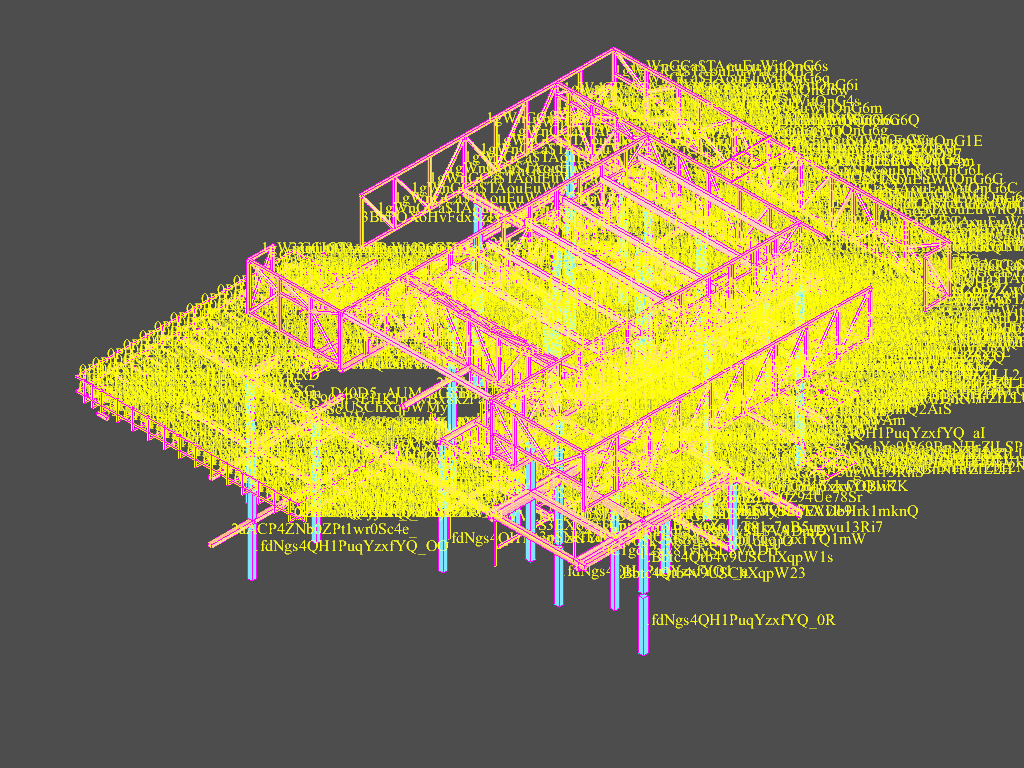

In [39]:
# RenderInWindow(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)
RenderImage(renderElementsOBB, elements_shape=elements_shape, elements_obb=elements_obb)

In [40]:
collision_group_count = dict()
for collision_group in common_collisions:
    count = len(collision_group)
    
    if not collision_group_count.get(count):
        collision_group_count[count] = list()

    collision_group_count[count].append(collision_group)

[f"# {key } collisions: {len(val)}" for key, val in sorted(collision_group_count.items())]

['# 1 collisions: 115',
 '# 2 collisions: 235',
 '# 3 collisions: 194',
 '# 4 collisions: 50',
 '# 5 collisions: 168',
 '# 6 collisions: 78',
 '# 7 collisions: 46',
 '# 8 collisions: 18',
 '# 9 collisions: 10',
 '# 10 collisions: 4',
 '# 11 collisions: 4',
 '# 12 collisions: 7',
 '# 13 collisions: 5',
 '# 14 collisions: 4',
 '# 16 collisions: 3',
 '# 17 collisions: 1',
 '# 18 collisions: 1',
 '# 19 collisions: 1',
 '# 23 collisions: 2',
 '# 26 collisions: 2',
 '# 29 collisions: 3',
 '# 30 collisions: 1',
 '# 34 collisions: 1',
 '# 38 collisions: 1']

In [41]:
knots = set()
remove_knots = set()
for group in common_collisions:
    count = 0
    gknots = set()
    for GUID in group:
        obb = elements_obb[GUID]
        collisions = list()
        for GUID2 in group:
            # if GUID == GUID2: continue

            obb2 = elements_obb[GUID2]
            collides = not obb.IsOut(obb2)

            if collides:
                count += 1
                collisions.append(GUID2)

        # print(collisions)
        knots.add(tuple(collisions))
        gknots.add(tuple(collisions))

    print(gknots)
    for gknot in gknots:
        for gknot2 in gknots:
            if gknot == gknot2: continue

            if len(gknot) <= len(gknot2): continue

            if not gknot2 in gknot:
                print("Remove", gknot)
                remove_knots.add(gknot2)


    print(len(group), count)




{('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy'), ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy'), ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy'), ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz'), ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2aACP4ZNb0ZPt1wr0Sc5Dy')}
Remove ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy')
Remove ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy')
Remove ('2BBRWyuiTArfU4s2dafGJk', '2ND9xRcJX2IOuHQq4PPME2', '2ND9xRcJX2IOuHQq4PPMJm', '2ND9xRcJX2IOuHQq4PPMnz', '2aACP4ZNb0ZPt1wr0Sc5Dy')
Remove ('2BBRWyuiTArfU4s2dafG

In [42]:
true_knots = remove_knots.intersection(knots)
# true_knots

In [43]:
# print(len(common_collisions))
# count = 3
# collision_group = collision_group_count[count][0]

# collision_group = list(knots)[1]
collision_group = list(true_knots)[500]
print(len(true_knots))

elements_group = [model.by_guid(GUID) for GUID in collision_group]
selected_guids = collision_group
selected_guids = list(common_collisions)[41]
len(elements_group)

1426


3

In [44]:
collision_group = list(common_collisions)[41]
collision_group

('1Gi0olEdzCPe8KlwbmpW54', '1Gi0olEdzCPe8KlwbmpW5P', '1Gi0olEdzCPe8KlwbmpWAI')

In [45]:
GUID = '0785r_tan1DgBgGMKaJe1a'
selected_guids = [GUID, *element_collisions[GUID]]

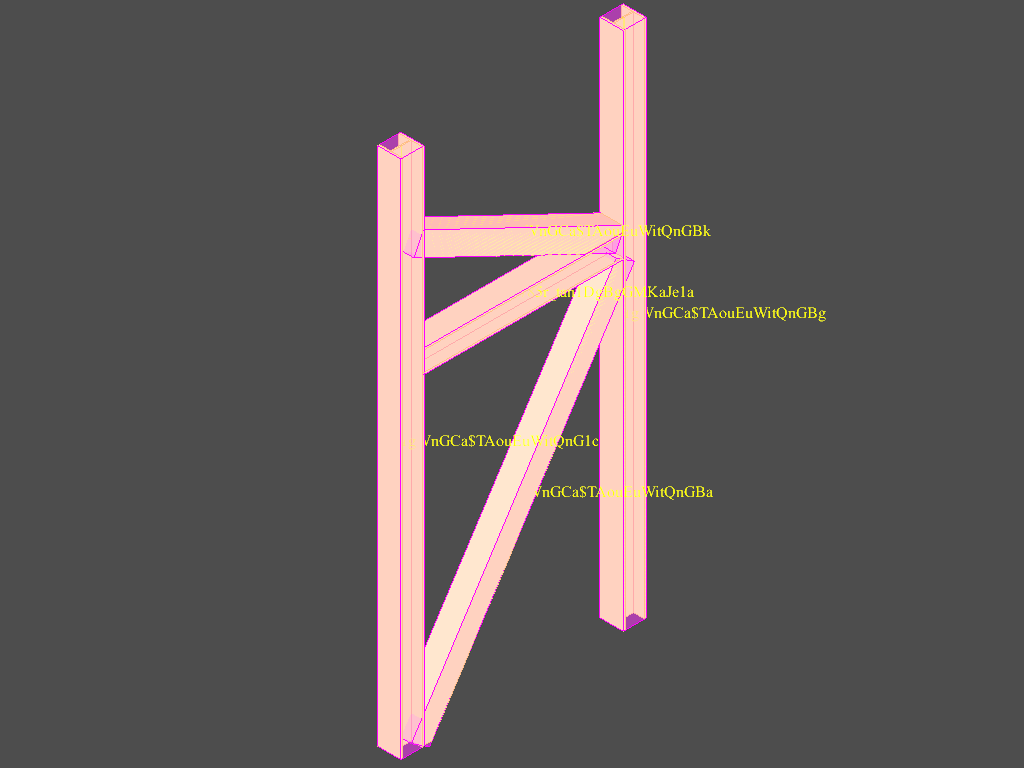

In [46]:
selected_obb = {GUID: elements_obb.get(GUID) for GUID in selected_guids}
selected_shapes = {GUID: elements_shape.get(GUID) for GUID in selected_guids}

# RenderInWindow(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_group})
# RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_group})
# RenderInWindow(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)
RenderImage(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)

In [47]:
from OCC.Core.BRepAlgoAPI import BRepAlgoAPI_Common, BRepAlgoAPI_Section, BRepAlgoAPI_BooleanOperation
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeWedge

In [48]:
column = '1gWnGCa$TAouEuWitQnG6O'
beam1 = '1gWnGCa$TAouEuWitQnG8y' # Diagonal
beam2 = '1gWnGCa$TAouEuWitQnG5y'
beam3 = '1gWnGCa$TAouEuWitQnG6A' # Long
beam3 = '1gWnGCa$TAouEuWitQnG6A' # Long

selected_guids = {
    column, beam1, beam2, beam3
}

selected_obb = {GUID: elements_obb.get(GUID) for GUID in selected_guids}
selected_shapes = {GUID: elements_shape.get(GUID) for GUID in selected_guids}

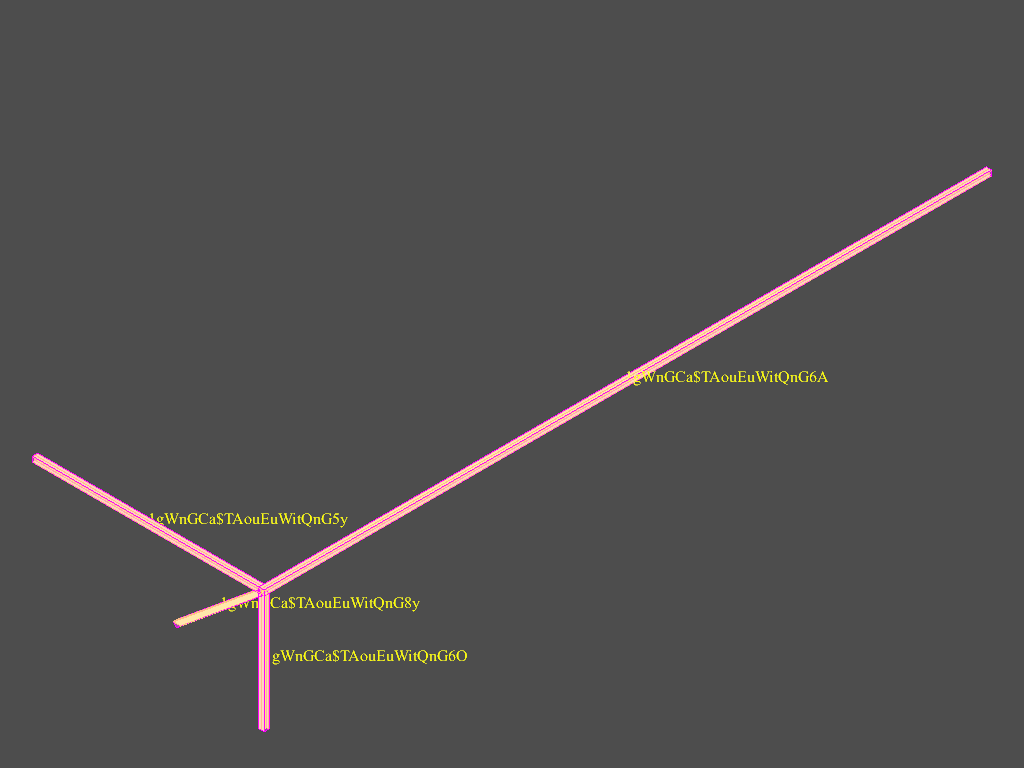

In [49]:
RenderImage(renderElementsOBB, elements_shape=selected_shapes, elements_obb=selected_obb)

In [50]:
from OCC.Core.gp import gp_Pnt
from OCC.Core.BRepPrimAPI import BRepPrimAPI_MakeBox
from OCC.Core.BRepMesh import BRepMesh_IncrementalMesh
from OCC.Core.BRepExtrema import BRepExtrema_ShapeProximity

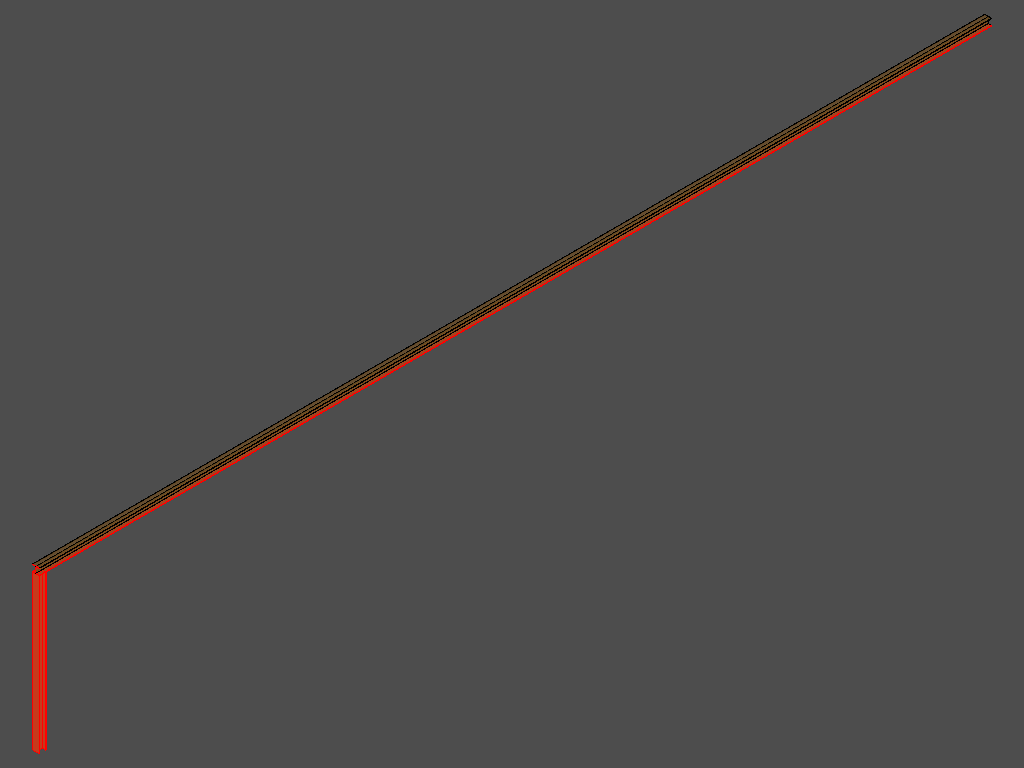

In [51]:
def renderIntersect(renderer, **args):

    box1 = elements_shape[column].geometry
    box2 = elements_shape[beam3].geometry

    # create two boxes that intersect
    # box1 = BRepPrimAPI_MakeBox(gp_Pnt(0, 0, 0), gp_Pnt(20, 20, 20)).Shape()
    # box2 = BRepPrimAPI_MakeBox(gp_Pnt(20.01, 10, 10), gp_Pnt(30, 30, 30)).Shape()

    # Create meshes for the proximity algorithm
    deflection = 1e-3
    mesher1 = BRepMesh_IncrementalMesh(box1, deflection)
    mesher2 = BRepMesh_IncrementalMesh(box2, deflection)
    mesher1.Perform()
    mesher2.Perform()

    # Perform shape proximity check
    tolerance = 0.000005
    isect_test = BRepExtrema_ShapeProximity(box1, box2, tolerance)
    isect_test.Perform()

    # Get intersecting faces from Shape1
    overlaps1 = isect_test.OverlapSubShapes1()
    face_indices1 = overlaps1.Keys()
    shape_1_faces = []
    for ind in face_indices1:
        face = isect_test.GetSubShape1(ind)
        shape_1_faces.append(face)

    # Get intersecting faces from Shape2
    overlaps2 = isect_test.OverlapSubShapes2()
    face_indices2 = overlaps2.Keys()
    shape_2_faces = []
    for ind in face_indices2:
        face = isect_test.GetSubShape2(ind)
        shape_2_faces.append(face)

    # renderer both boxes and intersecting faces, in RED
    renderer.DisplayShape(box1, transparency=0.5)
    renderer.DisplayShape(box2, transparency=0.5)
    renderer.DisplayShape(shape_1_faces + shape_2_faces, color="RED")
    # renderer.DisplayShape(shape_1_faces, color="RED")
    # print(overlaps1.Get)

    # subshp1 = isect_test.
    # print(subshp1)
    # renderer.DisplayShape(subshp1, color="RED")

    renderer.FitAll()

RenderImage(renderIntersect)

Minimal distance between cubes:  1.70174985214544e-12
12
False


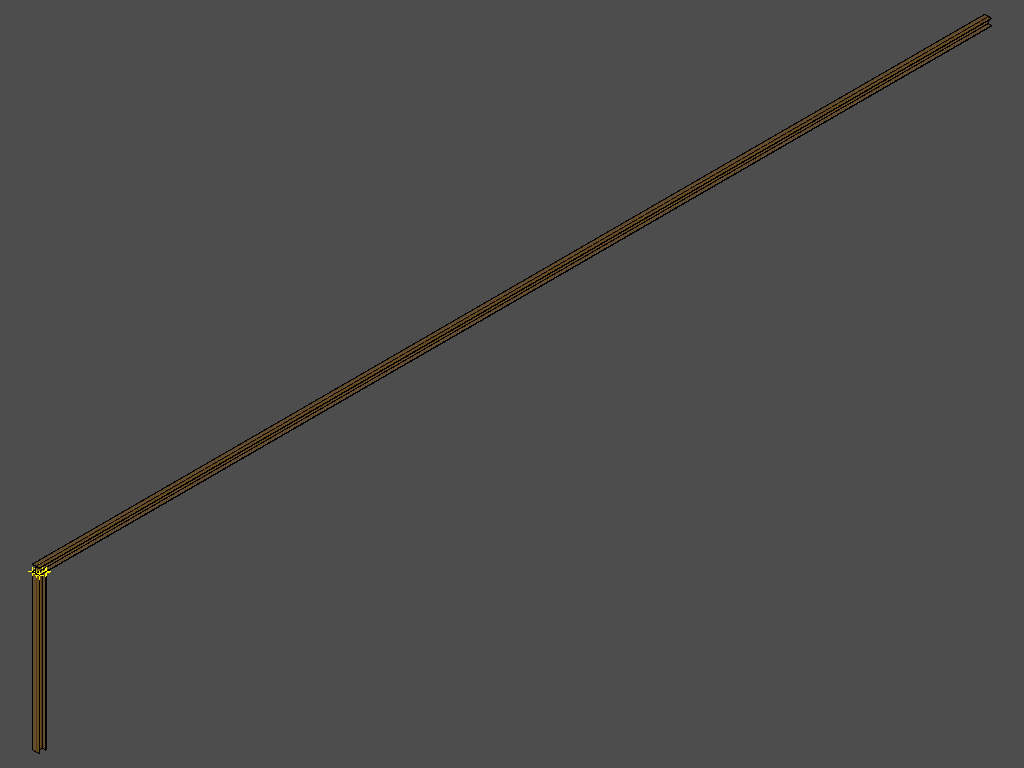

In [52]:
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
# import OCC.Core.BRepExtrema
from OCC.Extend.ShapeFactory import make_edge, make_vertex


# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect2(renderer, **args):

    b1 = elements_shape[column].geometry
    b2 = elements_shape[beam3].geometry
    # b2 = elements_shape['1qi89aVqvCRRthDWCeA1T0'].geometry

    # b1 = BRepPrimAPI_MakeBox(gp_Pnt(100, 0, 0), 10.0, 10.0, 10.0).Shape()
    # b2 = BRepPrimAPI_MakeBox(gp_Pnt(45, 45, 45), 10.0, 10.0, 10.0).Shape()
    renderer.DisplayShape([b1, b2], transparency=0.5)

    dss = BRepExtrema_DistShapeShape()
    dss.LoadS1(b1)
    dss.LoadS2(b2)
    dss.Perform()

    assert dss.IsDone()

    print("Minimal distance between cubes: ", dss.Value())


    print(dss.NbSolution())
    print(dss.InnerSolution())
    for i in range(dss.NbSolution()):
        edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
        renderer.DisplayColoredShape([edg], color="CYAN")

        renderer.DisplayShape(dss.PointOnShape1(1 + i))
        renderer.DisplayShape(dss.PointOnShape2(1 + i))
        # print(dss.SupportTypeShape1(1+i))
    

    renderer.FitAll()

RenderImage(renderIntersect2)
# RenderInWindow(renderIntersect2)

In [53]:
element_collisions

{'1z9uceUfrApQ_nV$wi6$_0': ['1z9uceUfrApQ_nV$si6$_0',
  '2efmnDma19OOWoMajftpZC'],
 '1z9uceUfrApQ_nV$wi6_k3': ['1z9uceUfrApQ_nV$si6_k3',
  '2efmnDma19OOWoMajftpZC'],
 '0PBox$QKjEKQwoUJvZkxWQ': ['0PBox$QKjEKQwoUJvZkvR6',
  '0PBox$QKjEKQwoUJvZkvRX'],
 '3nZkC8IfX01AVQOn6Y4Abl': ['3aMs4FkdDBUuSZCYtPiKWr',
  '1Qqm_D40D5_AUMnhG8nITv',
  '2Bbtc4Qtb4v9USChXqpWMy'],
 '1z9uceUfrApQ_nT$_i6_zB': [],
 '16iVztvQvBdxi_mREc59oZ': ['0PBox$QKjEKQwoUJvZkwxq',
  '0PBox$QKjEKQwoUJvZkwHk',
  '0PBox$QKjEKQwoUJvZkwHi',
  '0PBox$QKjEKQwoUJvZkwbp',
  '3cnJuO8zzBPenu_2r6jxDl'],
 '2Bbtc4Qtb4v9USChXqpWAm': ['1m01foOoj5SwOJWXDjiaux'],
 '1z9uceUfrApQ_nT$_i6__K': [],
 '1z9uceUfrApQ_nV$wi6y4g': ['1z9uceUfrApQ_nV$si6y4g'],
 '1aEOgM_rL7hQ$$S3UgBVFd': [],
 '1gWnGCa$TAouEuWitQnGBm': ['1gWnGCa$TAouEuWitQnG4O',
  '1gWnGCa$TAouEuWitQnGBW',
  '1gWnGCa$TAouEuWitQnG1c',
  '1gWnGCa$TAouEuWitQnGBc'],
 '0PBox$QKjEKQwoUJvZkxgm': ['0PBox$QKjEKQwoUJvZkvJM',
  '16iVztvQvBdxi_mREc598I'],
 '1z9uceUfrApQ_nV$si6_aP': ['1z9uceUfrApQ_nV$wi6

In [54]:
guids_inBox = {elm.GlobalId for elm in tree.select((8.0,10.0,3.0), extend=20.0)}
len(guids_inBox)

1198

In [55]:
elements_guids = {elm.GlobalId for elm in
                  list(ifcopenshell.util.selector.filter_elements(model,
                    "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))
                    }
len(elements_guids)

1017

In [56]:
# selected_guids = guids_inBox.intersection(elements_guids)
selected_guids = elements_guids
len(selected_guids)

1017

In [57]:
# some_collisions = {list(element_collisions.keys())[i]: list(element_collisions.values())[i] for i in range(100)}
some_collisions = {GUID: element_collisions[GUID] for GUID in selected_guids}
len(some_collisions)

1017

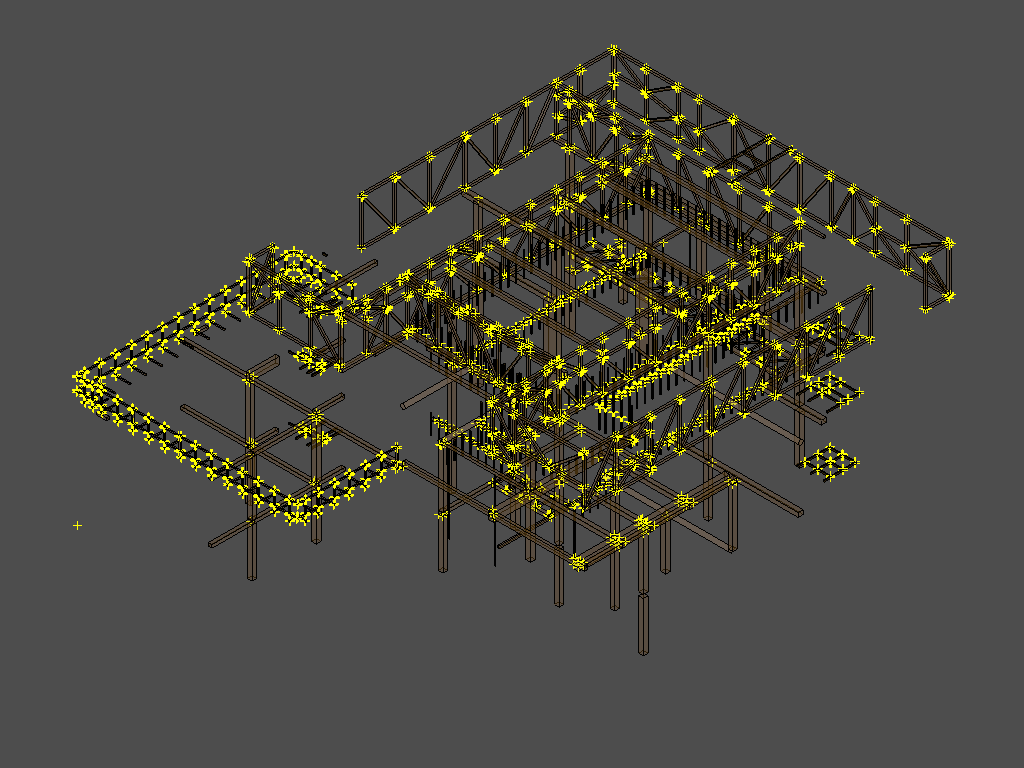

In [58]:
# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect3(renderer, **args):
    element_collisions = args['element_collisions']

    for this, others in element_collisions.items():
        this_obb_ = elements_obb[this]
        this_obb = Bnd_OBB()
        this_obb.Add(this_obb_)
        this_obb.Enlarge(0.001)
        b1 = convert_bnd_to_shape(this_obb)
        renderer.DisplayShape(b1, transparency=0.8)
        
        for other in others:
            other_obb = elements_obb[other]
            b2 = convert_bnd_to_shape(other_obb)


            # renderer.DisplayShape([b1, b2], transparency=0.8)

            dss = BRepExtrema_DistShapeShape()
            dss.LoadS1(b1)
            dss.LoadS2(b2)
            dss.Perform()

            assert dss.IsDone()

            # print("Minimal distance between cubes: ", dss.Value())


            # print(dss.NbSolution())
            # print(dss.InnerSolution())
            for i in range(dss.NbSolution()):
                # edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
                # renderer.DisplayColoredShape([edg], color="CYAN")

                renderer.DisplayShape(dss.PointOnShape1(1 + i))
                renderer.DisplayShape(dss.PointOnShape2(1 + i))
                # print(dss.SupportTypeShape1(1+i))
        

    renderer.FitAll()

# collisions = element_collisions
collisions = some_collisions
# RenderInWindow(renderIntersect3, element_collisions=collisions)
RenderImage(renderIntersect3, element_collisions=collisions)

Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vec

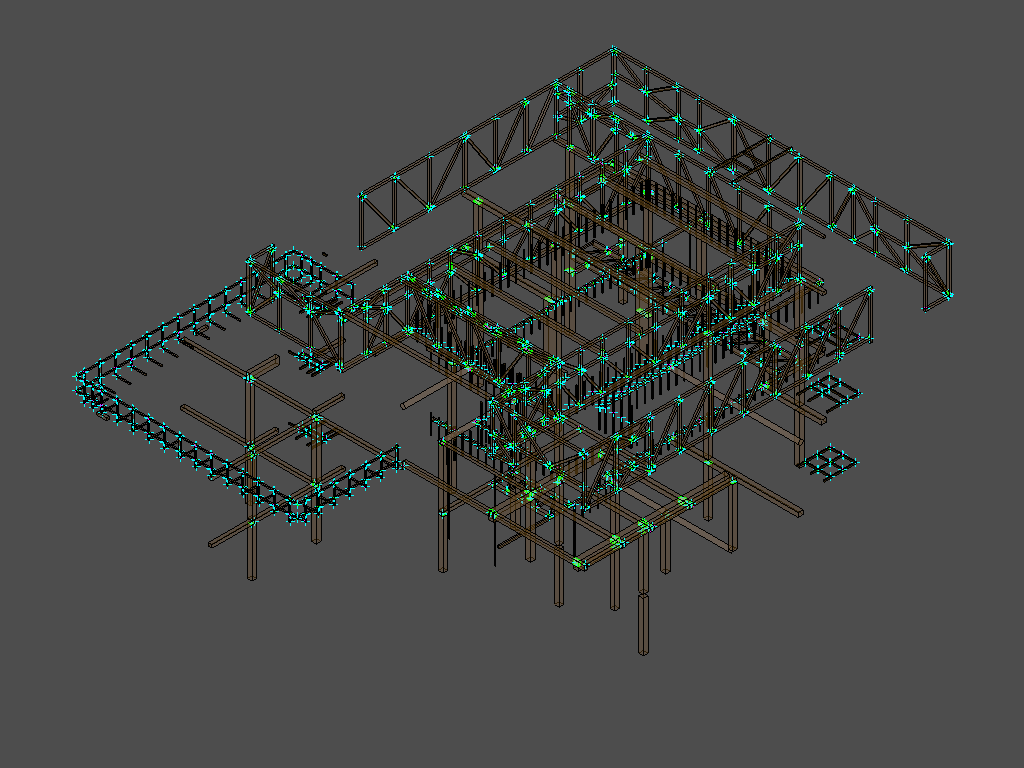

In [59]:
# https://old.opencascade.com/doc/occt-7.5.0/refman/html/class_b_rep_extrema___dist_shape_shape.html
def renderIntersect4(renderer, **args):
    element_collisions = args['element_collisions']

    global points
    global intersection_obbs
    points = list()
    intersection_obbs = list()

    i = 0
    #    GUID, GUID
    for this, others in element_collisions.items():
        this_obb_ = elements_obb[this]
        this_obb = Bnd_OBB()
        this_obb.Add(this_obb_)
        this_obb.Enlarge(0.001)
        b1 = convert_bnd_to_shape(this_obb)
        renderer.DisplayShape(b1, transparency=0.8)
        
        for other in others:
            try:
                other_obb = elements_obb[other]
                b2 = convert_bnd_to_shape(other_obb)

                solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

                intersection_obb = get_OBB(solidIntersection)
                intersection_obbs.append(intersection_obb)
                intersecion_shp = convert_bnd_to_shape(intersection_obb)
                centerPnt = gp_Pnt(intersection_obb.Center())

                points.append(centerPnt)

                color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)
                i += 1
                to_update = i % 50 == 0
                if to_update: i = 0
                renderer.DisplayShape(solidIntersection,
                                    color=color,
                                    transparency=0.8,
                                    update=to_update)
                

                color = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
                renderer.DisplayShape(
                    intersecion_shp,
                    color=color,
                )

                color = Quantity_Color(0.0, 1.0, 1.0, Quantity_TOC_RGB)
                renderer.DisplayShape(
                    centerPnt,
                    color=color,
                )
            except Exception as e:
                print(e)

            # dss = BRepExtrema_DistShapeShape()
            # dss.LoadS1(b1)
            # dss.LoadS2(b2)
            # dss.Perform()

            # assert dss.IsDone()

            # # print("Minimal distance between cubes: ", dss.Value())


            # # print(dss.NbSolution())
            # # print(dss.InnerSolution())
            # for i in range(dss.NbSolution()):
            #     # edg = make_edge(dss.PointOnShape1(1 + i), dss.PointOnShape2(1 + i))
            #     # renderer.DisplayColoredShape([edg], color="CYAN")

            #     renderer.DisplayShape(dss.PointOnShape1(1 + i))
            #     renderer.DisplayShape(dss.PointOnShape2(1 + i))
            #     # print(dss.SupportTypeShape1(1+i))
        

    renderer.FitAll()
    print("Done...")

# collisions = element_collisions
collisions = some_collisions
# RenderInWindow(renderIntersect4, element_collisions=collisions)
RenderImage(renderIntersect4, element_collisions=collisions)

In [60]:
print(len(points))
print(len(intersection_obbs))

3008
3022


In [61]:
new_obbs = list()
for obb in intersection_obbs:
    collisionCount = 0
    for new_obb in new_obbs:
        collides = not obb.IsOut(new_obb)
        if collides:
            new_obb.Add(obb)
            collisionCount += 1
    
    if collisionCount == 0:
        new_obb = Bnd_OBB()
        new_obb.Add(obb)
        new_obbs.append(new_obb)
    
    if collisionCount > 1:
        print(f"Warning! Collision Count: {collisionCount}!")

len(new_obbs)

Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 3!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Collision Count: 2!
Warning! Colli

966

In [62]:
obbs = list()
for new_obb in new_obbs:
    obb = Bnd_OBB()
    obb.Add(new_obb)
    obb.Enlarge(0.01)

    obbs.append(obb)

common_obbs = list()
for obb in obbs:
    collisionCount = 0

    for common_obb in common_obbs:
        collides = not obb.IsOut(common_obb)
        if collides:
            common_obb.Add(obb)
            collisionCount += 1
    
    if collisionCount == 0:
        common_obb = Bnd_OBB()
        common_obb.Add(obb)
        common_obbs.append(common_obb)
    
    if collisionCount > 1:
        print(f"Warning! Collision Count: {collisionCount}!")

len(common_obbs)

872

Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vector has zero norm raised from method gp_Dir of class gp_Dir
Standard_ConstructionErrorgp_Dir() - input vec

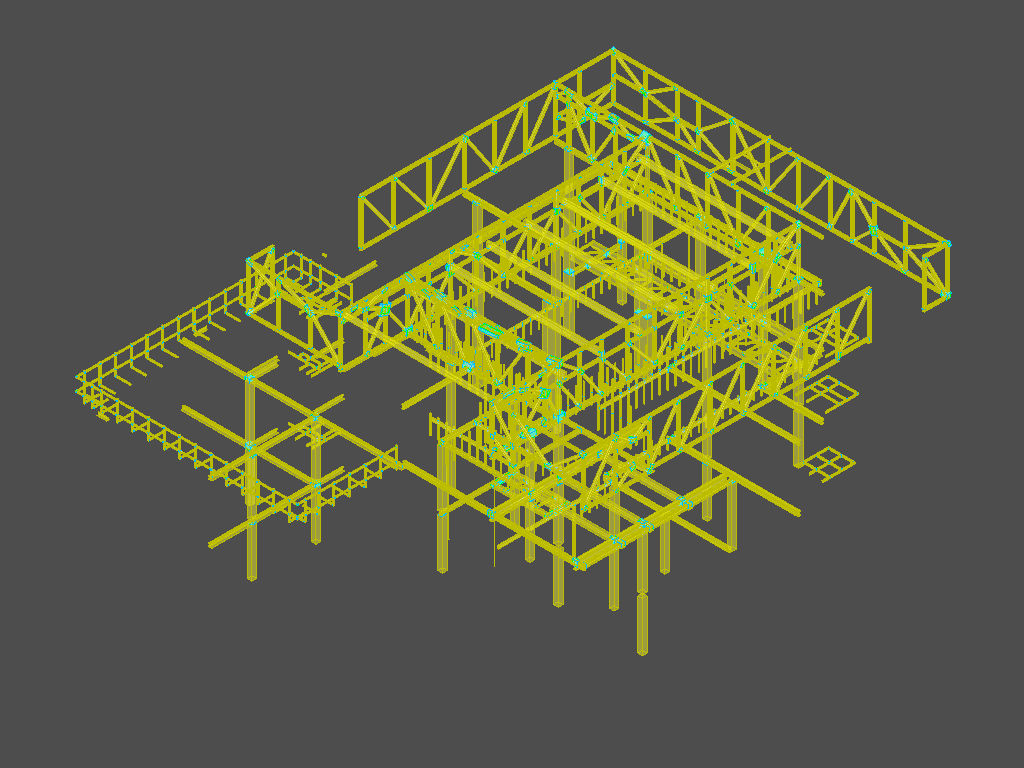

In [63]:
def renderObbs(renderer, **args):
    obbs = args['obbs']
    common_obbs = args['common_obbs']
    guids = args['guids']
    shapeData = args['shapeData']

    for i, GUID in enumerate(guids):
        to_update = i % 50 == 0

        shape = shapeData[GUID]['Body']

        color = Quantity_Color(0.5, 0.5, 0.0, Quantity_TOC_RGB)
        renderer.DisplayShape(
                shape.geometry,
                color=color,
                transparency=0.8,
                update=to_update,
        )

    for i, obb in enumerate(obbs):
        try:
            to_update = i % 50 == 0
            
            obb_shp = convert_bnd_to_shape(obb)

            color = Quantity_Color(0.0, 1.0, 0.0, Quantity_TOC_RGB)
            renderer.DisplayShape(
                    obb_shp,
                    color=color,
                    transparency=0.5,
                    update=to_update,
            )
        except Exception as e:
            print(e)

    for i, obb in enumerate(common_obbs):
        try:
            to_update = i % 50 == 0
            
            obb_shp = convert_bnd_to_shape(obb)

            color = Quantity_Color(0.0, 0.5, 1.0, Quantity_TOC_RGB)
            renderer.DisplayShape(
                    obb_shp,
                    color=color,
                    transparency=0.5,
                    update=to_update,
            )
        except Exception as e:
            print(e)

    renderer.FitAll()
    print("Done...")


# RenderInWindow(renderObbs, obbs=new_obbs, common_obbs=common_obbs, shapeData=shapeData, guids=selected_guids)
RenderImage(renderObbs, obbs=new_obbs, common_obbs=common_obbs, shapeData=shapeData, guids=selected_guids)

## New collision test

In [121]:
# elements = list(ifcopenshell.util.selector.filter_elements(model,
    # "IfcBeam + IfcColumn, /Pset_.*Common/.LoadBearing=TRUE"))

elements = list(ifcopenshell.util.selector.filter_elements(model,
    "IfcBuildingElement, /Pset_.*Common/.LoadBearing=TRUE"))

elements = {element.GlobalId: element for element in elements}
elements_shape = {GUID: shapeData[GUID]['Body'] for GUID in elements.keys()}

elements_obb = get_elementsOBB(elements_shape)
common_collisions, element_collisions = find_collisions(elements_obb)

In [122]:
collision_pairs = set()

alreadyFound = 0
i = 0
for GUID, collisions in element_collisions.items():
    # if len(collisions) == 0:
    #     print(f"{GUID} has zero collisions!")
    # if i > 20: break
    for OTHER_GUID in collisions:
        if GUID == OTHER_GUID:
            print("!!!!!!!!!!")
        i +=1
        
        col_pair = tuple(sorted([GUID, OTHER_GUID]))
        if col_pair in collision_pairs:
            alreadyFound += 1
        collision_pairs.add(col_pair)

# print(alreadyFound)
# print(i)
# len(collision_pairs)

In [253]:
obb_pairs = dict()

for col_pair in collision_pairs:
    GUID1, GUID2 = col_pair
    shp1 = shapeData[GUID1]['Body']
    shp2 = shapeData[GUID2]['Body']

    obb1 = get_OBB(shp1.geometry)
    obb2 = get_OBB(shp2.geometry)
    
    addF = 0.01
    mulF = 1.0
    elongatedObb1 = elongateOBB(obb1, mulF, addF)
    elongatedObb2 = elongateOBB(obb2, mulF, addF)
    
    elongatedObb1.Enlarge(0.002)
    elongatedObb2.Enlarge(0.002)

    obb_pairs[col_pair] = (elongatedObb1, elongatedObb2)
    

In [254]:
intersection_obbs = dict()

for col_pair, (obb1, obb2) in obb_pairs.items():
    b1 = convert_bnd_to_shape(obb1)
    b2 = convert_bnd_to_shape(obb2)
    solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

    intersection_obbs[col_pair] = solidIntersection
    

In [255]:
len(obb_pairs)

4824

In [257]:
GUIDS_single = set({
    *[GUID1 for (GUID1, GUID2) in obb_pairs.keys()],
    *[GUID2 for (GUID1, GUID2) in obb_pairs.keys()],
})
len(GUIDS_single)

1745

In [258]:
class Knot:
    def __init__(self, point: gp_Pnt, OBB: Bnd_OBB) -> None:
        self.point = point
        self.OBB = OBB
        self.columnDefined = None
        self.info = ""
        self.color = Quantity_Color(1.0, 0.0, 0.5, Quantity_TOC_RGB)

    def __str__(self) -> str:
        X = self.point.X()
        Y = self.point.Y()
        Z = self.point.Z()

        return f"Knot at ({X} {Y} {Z}). ColumnDefined: {self.columnDefined}"

    def makeColumnDefined(self, guids: set) -> None:
        self.columnDefined = True
        self.columnGuids = guids

    def setOriginInfo(self, info: str) -> None:
        self.info = info
    
    def setColor(self, color: Quantity_Color) -> None:
        self.color = color


In [259]:
def findColumnKnots(intersection_obbs):
    columnKnots = dict()

    for col_pair, solidIntersection in intersection_obbs.items():
        GUID1, GUID2 = col_pair

        # Check if both GUIDs refer to a column
        if False in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
            continue

        obb = get_OBB(solidIntersection)
        pnt = gp_Pnt(obb.Center())

        knot = Knot(pnt, obb)
        knot.makeColumnDefined(col_pair)
        knot.setColor(Quantity_Color(1.0, 0.0, 0., Quantity_TOC_RGB))

        columnKnots[col_pair] = knot

    return columnKnots

In [260]:
columnKnots = findColumnKnots(intersection_obbs)
len(columnKnots)

97

In [261]:
list(columnKnots)[5]

('1z9uceUfrApQ_nV$si6_Rr', '1z9uceUfrApQ_nV$wi6_Rr')

In [292]:
def findWeakColumnKnots(intersection_obbs, columnKnots):
    weakKnots = dict()
    global specialIntersections
    specialIntersections = dict()
    for col_pair, solidIntersection in intersection_obbs.items():
        if col_pair in columnKnots:
            # print("Already defined")
            continue

        GUID1, GUID2 = col_pair

        # Check if one or more GUIDS refer to IfcColum
        if not True in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
            continue
        
        if elements[GUID1].is_a('IfcColumn'):
            COL_GUID = GUID1
            OTHER_GUID = GUID2
        else:
            COL_GUID = GUID2
            OTHER_GUID = GUID1

        column_obb = elements_obb[COL_GUID]
        other_obb = elements_obb[OTHER_GUID]

        addF = 10.0
        mulF = 1.0
        elongatedObb = elongateOBB(column_obb, mulF, addF)
        elongatedObb.Enlarge(0.01)

        b1 = convert_bnd_to_shape(elongatedObb)
        b2 = convert_bnd_to_shape(other_obb)
        solidIntersection = BRepAlgoAPI_Common(b1, b2).Shape()

        obb = get_OBB(solidIntersection)
        # print(obb.SquareExtent())
        # print(obb.XHSize(), obb.YHSize(), obb.ZHSize())
        if obb.ZHSize() <= 0:
            specialIntersections[col_pair] = solidIntersection
            continue
        
        
        pnt = gp_Pnt(obb.Center())

        knot = Knot(pnt, obb)
        knot.makeColumnDefined(col_pair)

        weakKnots[col_pair] = knot

    return weakKnots

In [293]:
weakKnots = findWeakColumnKnots(intersection_obbs, columnKnots)
len(weakKnots)

825

In [294]:
len(specialIntersections)

0

In [295]:
def renderColumnKnots(renderer, **args):
    for key, knot in (columnKnots | weakKnots).items():
        obb_shp = convert_bnd_to_shape(knot.OBB)

        color = knot.color

        ais = renderer.DisplayShape(
            obb_shp,
            transparency=0.3,
            color = color,
        )


    renderer.FitAll()
    print("Done...")

RenderInWindow(renderColumnKnots)

INFO:OCC.Display.backend:The qt-pyqt5 backend is already loaded...``load_backend`` can only be called once per session
qt-pyqt5 backend - Qt version 5.15.8
Done...


INFO:OCC.Display.backend:The qt-pyqt5 backend is already loaded...``load_backend`` can only be called once per session


qt-pyqt5 backend - Qt version 5.15.8
Done...
Done...
Done...
Done...


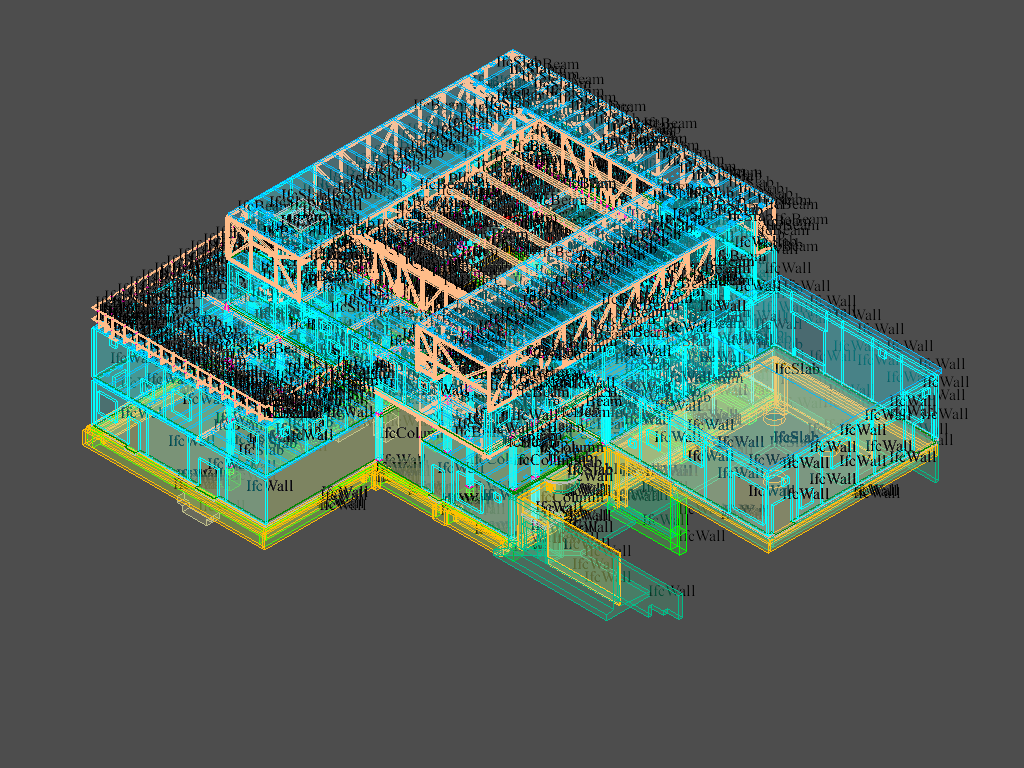

In [297]:
def renderColPairs(renderer, **args):
    global some_obbs
    global shapeData
    global GUIDS_single


    renderColumnKnots(renderer)

    for key, intersecion in specialIntersections.items():
        renderer.DisplayShape(
            intersecion,
            # color = color,
            # transparency=transparency,
            # update=to_update,
        )


    # for obb in some_obbs:
    #     obb_shp = convert_bnd_to_shape(obb)

    #     renderer.DisplayShape(
    #         obb_shp,
    #     )

    # for col_pair, (obb1, obb2) in obb_pairs.items():
    #     try:
    #         b1 = convert_bnd_to_shape(obb1)
    #         b2 = convert_bnd_to_shape(obb2)

    #         color = Quantity_Color(1.0, 0.5, 0.5, Quantity_TOC_RGB)
    #         renderer.DisplayShape(
    #             [b1, b2],
    #             transparency=0.7,
    #             color = color,
    #         )

    #     except Exception as e:
    #         print(e)


    # for col_pair, solidIntersection in intersection_obbs.items():
    #     color = Quantity_Color(1.0, 0.0, 1.0, Quantity_TOC_RGB)
    #     GUID1, GUID2 = col_pair

    #     # Check if one or more GUIDS refer to IfcColum
    #     if not True in [elements[GUID].is_a('IfcColumn') for GUID in [GUID1, GUID2]]:
    #         continue

    #     ais = renderer.DisplayShape(
    #         solidIntersection,
    #         transparency=0.3,
    #         color = color,
    #     )


    for GUID in GUIDS_single:
        pdct_shape = shapeData[GUID]['Body']

        r,g,b,alpha = pdct_shape.styles[0] # the shape color
        color = Quantity_Color(abs(r), abs(g), abs(b), Quantity_TOC_RGB)

        transparency = abs(1 - alpha)

        transparency = 0.5
        if not elements[GUID].is_a('IfcColumn'):
            transparency = 0.95


        renderer.DisplayShape(
            pdct_shape.geometry,
            color = color,
            transparency=transparency,
            # update=to_update,
        )

        obb = elements_obb[GUID]
        textLabel = AIS_TextLabel()
        textLabel.SetPosition(gp_Pnt(obb.Center()))
        # textLabel.SetText(TCollection_ExtendedString(f"{GUID}"))
        textLabel.SetText(TCollection_ExtendedString(f"{elements[GUID].is_a()}"))
        color = Quantity_Color(0.0, 0.0, 0.0, Quantity_TOC_RGB)
        textLabel.SetColor(color)
        
        renderer.Context.Display(textLabel, False)






    renderer.FitAll()
    print("Done...")

RenderInWindow(renderColPairs)
RenderImage(renderColPairs)

In [141]:
pdct_shape = shapeData['1P7bTXjRH7neqxrKOuprpg']['Body']
pdct_shape

shape_tuple(data=<ifcopenshell.ifcopenshell_wrapper.SerializedElement; proxy of <Swig Object of type 'IfcGeom::SerializedElement *' at 0x000001E1E49F50B0> >, geometry=<class 'TopoDS_Compound'>, styles=((1.0, 0.5019607843137255, 0.25098039215686274, 1.0),), style_ids=(26576,))

In [143]:
shape = pdct_shape.geometry
shape

<class 'TopoDS_Compound'>

## Other stuff

In [70]:
from OCC.Core.gp import gp_Pnt
from OCC.Core.TopoDS import TopoDS_Vertex
from OCC.Core.BRepBuilderAPI import BRepBuilderAPI_MakeVertex
from OCC.Core.BRep import BRep_Tool
# from OCC.Core.BRepTools import BRepTools
from OCC.Core.TopExp import TopExp_Explorer
from OCC.Core.TColgp import TColgp_Array1OfPnt
from OCC.Core.BRepAdaptor import BRepAdaptor_Curve
from OCC.Core.BRepExtrema import BRepExtrema_DistShapeShape
# from OCC.Core.BRepAdaptor import BRepAdaptor_HVertex
# from OCC.Core.BRepAdaptor 


In [71]:
# Create Box
# axe = gp_Ax2(gp_Pnt(10, 10, 10), gp_Dir(1, 2, 1))
# Box = BRepPrimAPI_MakeBox(axe, 60, 80, 100).Shape()
# # # Create wedge
# Wedge = BRepPrimAPI_MakeWedge(60.0, 100.0, 80.0, 20.0).Shape()
# Common surface


# Box = convert_bnd_to_shape(elements_obb[column])
# Wedge = convert_bnd_to_shape(elements_obb[beam3])


# Box = elements_obb[column]
# Wedge = elements_obb[beam1]

Box = elements_shape[column].geometry
Wedge = elements_shape[beam1].geometry

CommonSurface = BRepAlgoAPI_Common(Box, Wedge).Shape()

common_obb = get_OBB(CommonSurface)
# common_obb.Enlarge(0.2)
common_obbShp = convert_bnd_to_shape(common_obb)

print(f"Box: {Box}")
print(f"Wedge: {Wedge}")
print(f"CommonSurface: {CommonSurface}")
print(f"Common_obb: {common_obb}")
print(f"Common_obbShp: {common_obbShp}")

Box: <class 'TopoDS_Compound'>
Wedge: <class 'TopoDS_Compound'>
CommonSurface: <class 'TopoDS_Compound'>
Common_obb: <class 'Bnd_OBB'>
Common_obbShp: <class 'TopoDS_Solid'>


In [72]:
def renderFunc(renderer, **args):
    
    try:
        renderer.EraseAll()
        ais_box = renderer.DisplayShape(Box)[0]
        ais_wedge = renderer.DisplayShape(Wedge)[0]
        renderer.Context.SetTransparency(ais_box, 0.8, True)
        renderer.Context.SetTransparency(ais_wedge, 0.8, True)
        renderer.DisplayShape(common_obbShp, color=rgb_color(0.0, 1.0, 1.0), transparency=0.5)
        renderer.DisplayShape(CommonSurface, color=rgb_color(1.0, 0.0, 1.0),transparency=0.5)    
        
        bbox, bboxShp = FitToShape(renderer, common_obbShp)
        # renderer.DisplayShape(bboxShp, color=rgb_color(0.0, 1.0, 0.0),transparency=0.5)

        # renderer.SetModeWireFrame()
        # renderer.FitAll()

    except Exception as e:
        print(f"Exception!: {e}")

    print(args)


{'testarg': 'abc'}


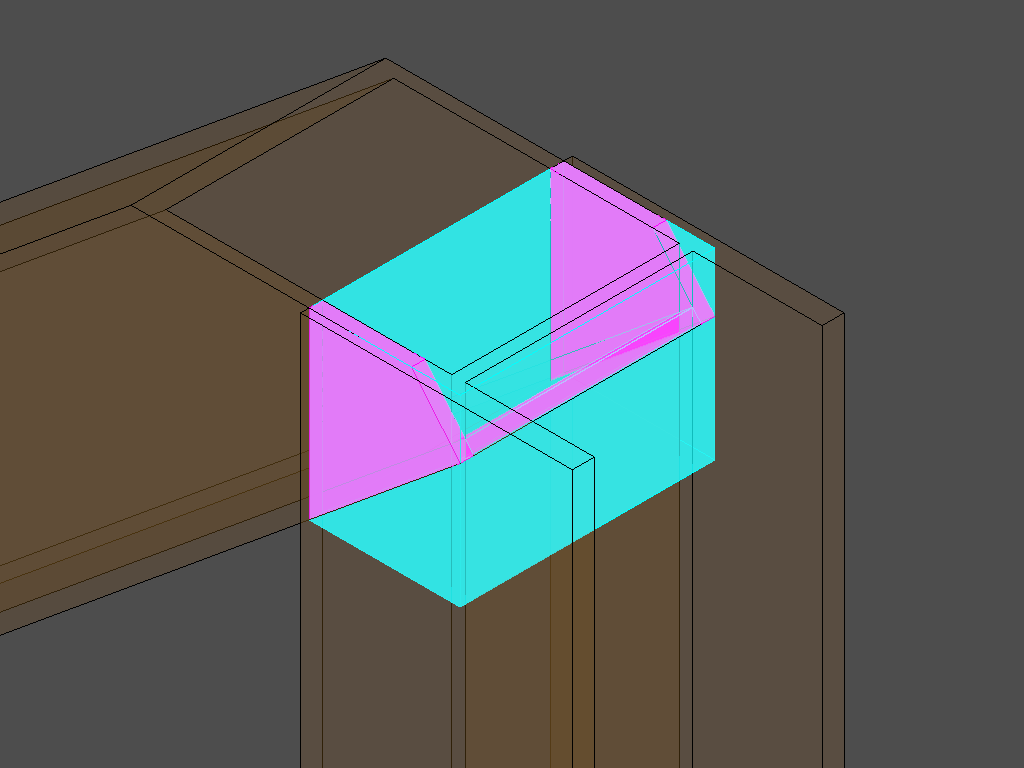

In [73]:
RenderImage(renderFunc,  testarg='abc')

**Tests**...:

In [74]:
beam = model.by_guid(guids[0])
beam

#13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.)

In [75]:
elements = tree.select_box(beam, extend=0.001)
elements

[#12571=IfcBeam('1gWnGCa$TAouEuWitQnG1a',#18,'Rectangular and Square Hollow Sections:SB40:1803480',$,'Rectangular and Square Hollow Sections:SB40',#12570,#12567,'1803480',.BEAM.),
 #13918=IfcBeam('1gWnGCa$TAouEuWitQnG6O',#18,'H-Wide Flange Beams:SB30:1803556',$,'H-Wide Flange Beams:SB30',#13917,#13914,'1803556',.BEAM.),
 #17256=IfcBeam('1gWnGCa$TAouEuWitQnG5o',#18,'H-Wide Flange Beams:SB30:1803726',$,'H-Wide Flange Beams:SB30',#17255,#17252,'1803726',.BEAM.),
 #20668=IfcBeam('1gWnGCa$TAouEuWitQnG8y',#18,'Rectangular and Square Hollow Sections:SB40:1803904',$,'Rectangular and Square Hollow Sections:SB40',#20667,#20664,'1803904',.BEAM.),
 #14478=IfcBeam('1gWnGCa$TAouEuWitQnG64',#18,'H-Wide Flange Beams:SB30:1803576',$,'H-Wide Flange Beams:SB30',#14477,#14474,'1803576',.BEAM.),
 #12571=IfcBeam('1gWnGCa$TAouEuWitQnG1a',#18,'Rectangular and Square Hollow Sections:SB40:1803480',$,'Rectangular and Square Hollow Sections:SB40',#12570,#12567,'1803480',.BEAM.),
 #13918=IfcBeam('1gWnGCa$TAouEuWit

In [76]:
project = model.by_type('IfcProject')[0]
project

#93=IfcProject('3yHhRiYMfCAOAtv2MmnXRn',#18,'17-0279',$,$,'LLYN.B374','AS BUILT',(#86,#91),#82)

In [77]:
project.UnitsInContext

#82=IfcUnitAssignment((#19,#21,#22,#26,#27,#30,#31,#33,#34,#35,#37,#40,#42,#46,#47,#48,#49,#50,#51,#52,#53,#54,#55,#60,#62,#64,#67,#68,#69,#70,#71,#72,#73,#74,#76,#77,#78,#79,#80,#81))

In [78]:
ifcopenshell.util.unit.get_project_unit(model, 'LENGTHUNIT')

#19=IfcSIUnit(*,.LENGTHUNIT.,.MILLI.,.METRE.)

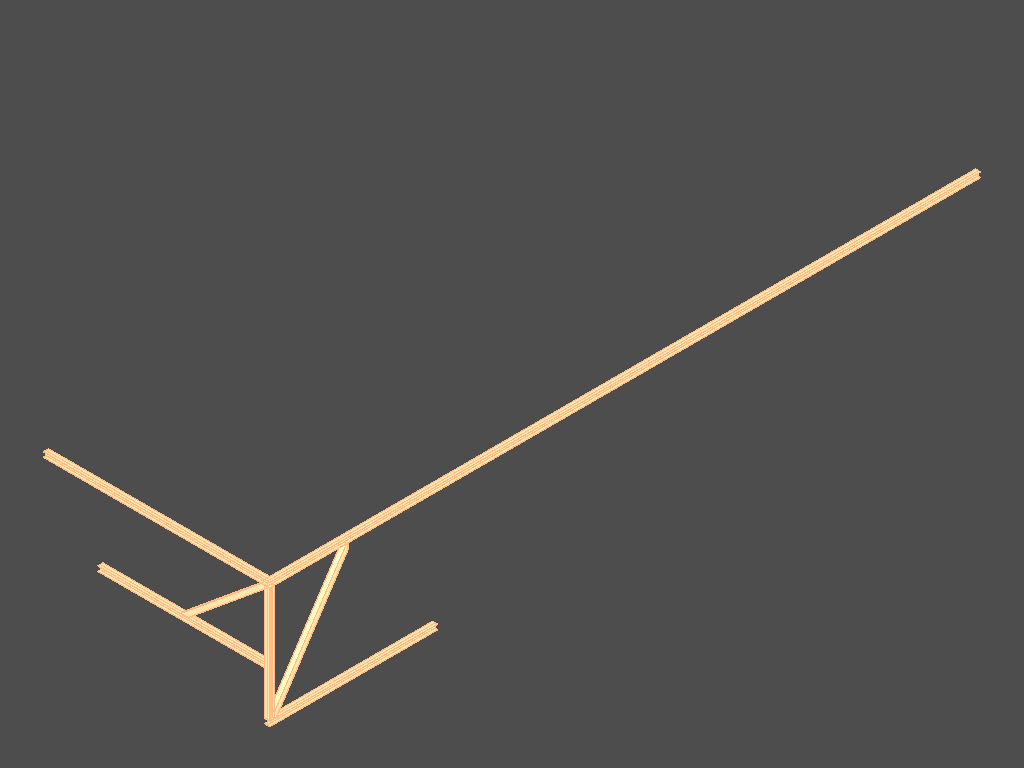

In [79]:
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements})

In [80]:
tree.select((0.0,1.0,0.0), extend=1.0)

[#30711=IfcWall('1y5zR70q9Ei91j17LgWJjD',#18,'Basic Wall:VE20-0:2141291',$,'Basic Wall:VE20-0',#30684,#30710,'2141291',.NOTDEFINED.),
 #30811=IfcWall('2jLI9K8E5EMw$NqVQCu6VH',#18,'Basic Wall:VE20-0:2145372',$,'Basic Wall:VE20-0',#30780,#30810,'2145372',.NOTDEFINED.),
 #6527=IfcWall('3T6FHmWKb6ZvXDr7YUs9wh',#18,'Basic Wall:FSS20:1208520',$,'Basic Wall:FSS20',#6512,#6526,'1208520',.NOTDEFINED.),
 #7225=IfcWall('0eZERX1xzDug5ZdIa0w5J6',#18,'Basic Wall:FSS20:1307796',$,'Basic Wall:FSS20',#7213,#7224,'1307796',.NOTDEFINED.),
 #49686=IfcWall('2OpXq0uIfC6egnlWE2fkHp',#18,'Basic Wall:IH25:2545696',$,'Basic Wall:IH25',#49667,#49685,'2545696',.NOTDEFINED.),
 #5368=IfcWall('1jLRC8MWH8yhQO3uVKRzKM',#18,'Basic Wall:FS50:1090729',$,'Basic Wall:FS50',#5353,#5367,'1090729',.NOTDEFINED.),
 #7225=IfcWall('0eZERX1xzDug5ZdIa0w5J6',#18,'Basic Wall:FSS20:1307796',$,'Basic Wall:FSS20',#7213,#7224,'1307796',.NOTDEFINED.),
 #6527=IfcWall('3T6FHmWKb6ZvXDr7YUs9wh',#18,'Basic Wall:FSS20:1208520',$,'Basic Wall:FSS

In [81]:
guids

['1gWnGCa$TAouEuWitQnG6O',
 '1gWnGCa$TAouEuWitQnG8y',
 '1gWnGCa$TAouEuWitQnG5y',
 '1gWnGCa$TAouEuWitQnG6A',
 '1gWnGCa$TAouEuWitQnG5o',
 '1gWnGCa$TAouEuWitQnGB2']

Length of list: 6


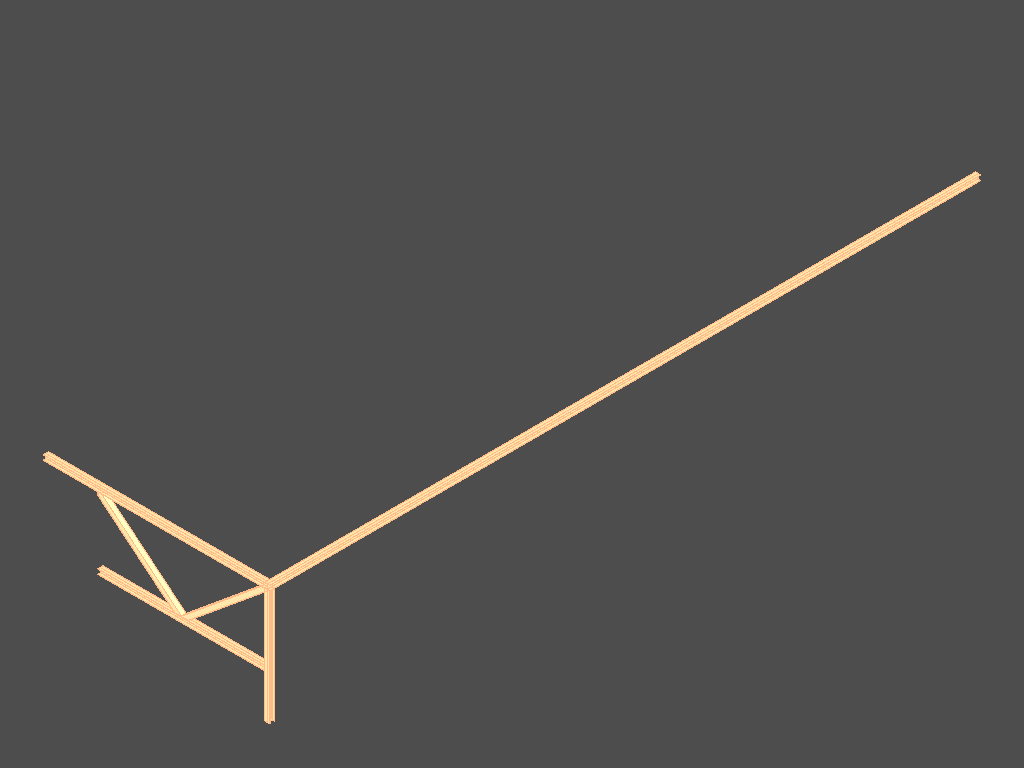

In [82]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})

### 3 steel beams, middle of beam

![](AdvBIM-A2_Analysis.ipynb_img/pasted_2023-10-20-11-30-59.png)

In [83]:
guids = [
    "1gWnGCa$TAouEuWitQnG5o",
    "1gWnGCa$TAouEuWitQnG8y",
    "1gWnGCa$TAouEuWitQnGB2",
]

Length of list: 3


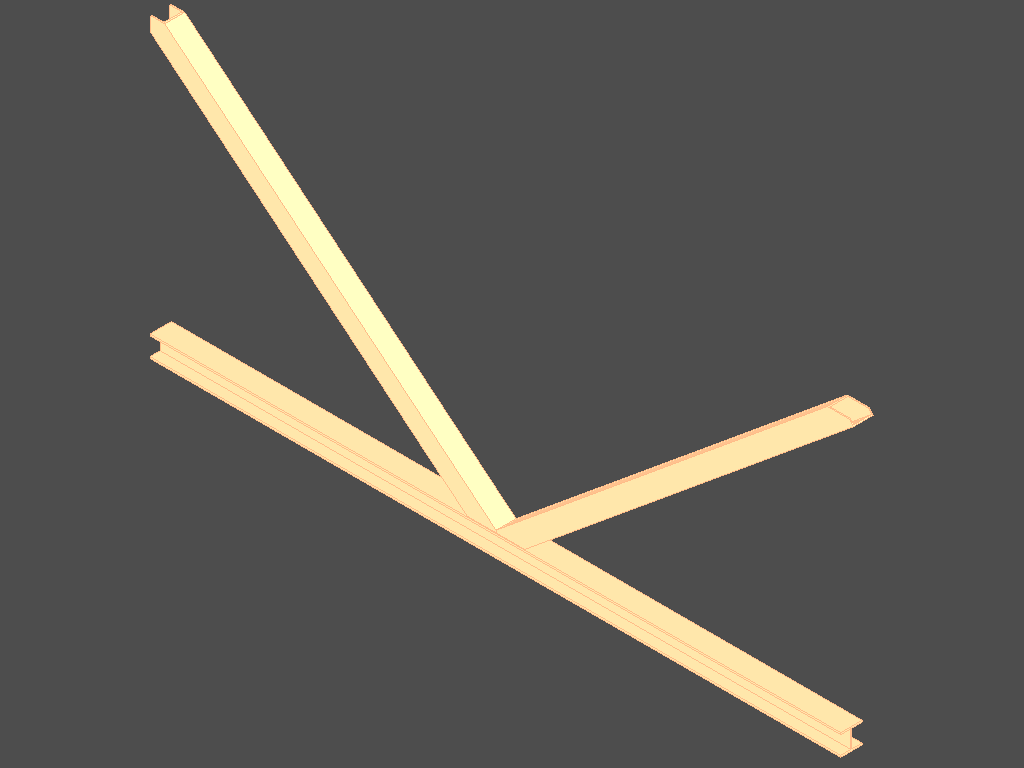

In [84]:
elements_render = utils.getElementsRender(guids, model)
RenderImage(ElementsRenderFunc, elements={element.GlobalId: element for element in elements_render})